In [19]:
import pandas as pd
import numpy as np

import rasterio
from skimage.transform import resize
from skimage.transform import rotate
import os

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import train_test_split

from datetime import timedelta
from skimage.draw import polygon
import matplotlib.pyplot as plt

from shapely.geometry import Polygon

#### Import Yield Data

In [2]:
# Load yield data
yield_data_path = "./combined_yield_data.csv"
yield_data = pd.read_csv(yield_data_path, parse_dates=['Date'], index_col='Date')

# Check data
print(yield_data.head())
print("\nNumber of Yield Data Points: ", len(yield_data))
print("\nColumn Names:", yield_data.columns)

            Volume (Pounds)  Cumulative Volumne (Pounds)  Pounds/Acre
Date                                                                 
2012-01-02          23400.0                      23400.0          2.0
2012-01-03          26064.0                      49464.0          3.0
2012-01-04          32382.0                      81846.0          3.0
2012-01-05          69804.0                     151650.0          7.0
2012-01-06          18000.0                     169650.0          2.0

Number of Yield Data Points:  3970

Column Names: Index(['Volume (Pounds)', 'Cumulative Volumne (Pounds)', 'Pounds/Acre'], dtype='object')


#### Process Yield Data

In [3]:
# Define the typical strawberry growing season as a temporal mask (so that we only consider when strawberries are being grown)
def is_strawberry_season(date):
    return date.month in [3, 4, 5, 6, 7, 8, 9, 10]

# Filter yield data to only include dates within the strawberry growing season
yield_data = yield_data[yield_data.index.map(is_strawberry_season)]

print("Number of Yield Data Points:", len(yield_data))

Number of Yield Data Points: 2879


#### Resample to be on a weekly basis

In [4]:
# Resample yield data to weekly frequency
yield_data_weekly = yield_data.resample('W').agg({
    'Volume (Pounds)': 'sum',
    'Cumulative Volumne (Pounds)': 'last',
    'Pounds/Acre': 'mean'
})

yield_data_weekly['Cumulative Volumne (Pounds)'] = yield_data_weekly['Cumulative Volumne (Pounds)'].ffill()
yield_data_weekly['Cumulative Volumne (Pounds)'] = yield_data_weekly['Cumulative Volumne (Pounds)'].cummax()
yield_data_weekly.fillna(0, inplace=True)

#### Add cyclical features for seasonality

In [5]:
# Add time features to yield data
yield_data_weekly['month'] = yield_data_weekly.index.month
yield_data_weekly['day_of_year'] = yield_data_weekly.index.dayofyear

# Cyclical encoding for month
yield_data_weekly['month_sin'] = np.sin(2 * np.pi * yield_data_weekly['month'] / 12)
yield_data_weekly['month_cos'] = np.cos(2 * np.pi * yield_data_weekly['month'] / 12)

# Cyclical encoding for day of year
yield_data_weekly['day_of_year_sin'] = np.sin(2 * np.pi * yield_data_weekly['day_of_year'] / 365)
yield_data_weekly['day_of_year_cos'] = np.cos(2 * np.pi * yield_data_weekly['day_of_year'] / 365)

# Drop original time features
yield_data_weekly.drop(['month', 'day_of_year'], axis=1, inplace=True)

print("Yield data with time features:")
print(yield_data_weekly.head())

Yield data with time features:
            Volume (Pounds)  Cumulative Volumne (Pounds)  Pounds/Acre  \
Date                                                                    
2012-03-04         525753.0                    1785843.0    18.333333   
2012-03-11        2949534.0                    4735377.0    51.666667   
2012-03-18        4772268.0                    9507645.0    83.500000   
2012-03-25        3142314.0                   12649959.0    55.000000   
2012-04-01        6271398.0                   18921357.0    93.857143   

            month_sin     month_cos  day_of_year_sin  day_of_year_cos  
Date                                                                   
2012-03-04   1.000000  6.123234e-17         0.891981         0.452072  
2012-03-11   1.000000  6.123234e-17         0.939856         0.341571  
2012-03-18   1.000000  6.123234e-17         0.974100         0.226116  
2012-03-25   1.000000  6.123234e-17         0.994218         0.107381  
2012-04-01   0.866025 -5.

#### Yield Data Normalization

In [6]:
scaler = MinMaxScaler()
yield_data_weekly[['Volume (Pounds)', 'Cumulative Volumne (Pounds)']] = scaler.fit_transform(yield_data_weekly[['Volume (Pounds)', 'Cumulative Volumne (Pounds)']])

#### Load and Preprocess EVI Data

In [7]:
# Define target shape (experimented with smaller; larger might perform better but might take longer to train)
target_shape = (512, 512)

# Directory containing the pre-filtered EVI data
evi_data_dir = './landsat_evi_monterey_masked'

# List all files
evi_files = [os.path.join(evi_data_dir, f) for f in os.listdir(evi_data_dir) if f.endswith('.tiff')]

# Function to load EVI data
def load_evi_data(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)
        return data

# Load EVI data
evi_data_dict = {}
for file in evi_files:
    try:
        date_str = os.path.basename(file).split('_')[3]
        date = pd.to_datetime(date_str, format='%Y%m%d')
        evi_data = load_evi_data(file)
        evi_data_dict[date] = resize((evi_data - np.min(evi_data)) / (np.max(evi_data) - np.min(evi_data) + 1e-8), target_shape, anti_aliasing=True)
    except Exception as e:
        print(f"Error processing file {file}: {e}")

#### Data Augmentation

In [8]:
# Function to augment image
def augment_image(image):
    # Apply random horizontal and vertical flips
    if np.random.rand() > 0.5:
        image = np.flipud(image)
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
    # Apply random rotation
    angle = np.random.uniform(-30, 30)  # Rotate between -30 to 30 degrees
    image = rotate(image, angle, mode='reflect')
    return image

# Apply augmentation to EVI data
evi_data_dict_aug = {date: augment_image(data) for date, data in evi_data_dict.items()}

# Combine original and augmented EVI data
evi_data_dict_combined = {f"{date}_aug": data for date, data in evi_data_dict_aug.items()}
evi_data_dict_combined.update(evi_data_dict)

# Update evi_reference to include augmented data
time_index = pd.date_range(start=yield_data_weekly.index[0], end=yield_data_weekly.index[-1], freq='W')
evi_reference = [min(evi_data_dict.keys(), key=lambda d: abs(d - week_start)) for week_start in time_index]
evi_reference_aug = [f"{date}_aug" for date in evi_reference]

# Combine original and augmented references
evi_reference_combined = evi_reference + evi_reference_aug

print("Number of samples in augmented dataset:", len(evi_reference_combined))

Number of samples in augmented dataset: 1282


In [9]:
class CustomDataset(Dataset):
    def __init__(self, evi_data_dict, evi_reference, yield_data, sequence_length=4):
        self.evi_data_dict = evi_data_dict
        self.evi_reference = evi_reference
        self.yield_data = yield_data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.yield_data) - self.sequence_length + 1

    def __getitem__(self, idx):
        evi_sequence = [self.evi_data_dict[self.evi_reference[idx + i]] for i in range(self.sequence_length)]
        evi_sequence = torch.tensor(evi_sequence, dtype=torch.float32).unsqueeze(1)
        yield_val = self.yield_data.iloc[idx + self.sequence_length - 1]['Volume (Pounds)']
        time_features = self.yield_data.iloc[idx + self.sequence_length - 1][['month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'Volume (Pounds)', 'Cumulative Volumne (Pounds)']].values
        return evi_sequence, torch.tensor(yield_val, dtype=torch.float32), torch.tensor(time_features, dtype=torch.float32)
    
# Create DataLoader
dataset = CustomDataset(evi_data_dict_combined, evi_reference_combined, yield_data_weekly)
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)

train_subset = torch.utils.data.Subset(dataset, train_indices)
test_subset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=4, shuffle=False)

#### Define the Model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using mps device


In [29]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.flattened_size = self._get_conv_output((1, *target_shape))
        self.fc1 = nn.Linear(self.flattened_size, 512)

    def _get_conv_output(self, shape):
        x = torch.rand(1, *shape)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        n_size = x.view(1, -1).size(1)
        return n_size

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        return x
    
class HybridModel(nn.Module):
    def __init__(self, cnn_feature_extractor, lstm_hidden_size=64, lstm_layers=1):
        super(HybridModel, self).__init__()
        self.cnn = cnn_feature_extractor
        self.lstm = nn.LSTM(input_size=512, hidden_size=lstm_hidden_size, num_layers=lstm_layers, batch_first=True)
        self.fc1 = nn.Linear(lstm_hidden_size + 6, 64)
        self.fc2 = nn.Linear(64, target_shape[0] * target_shape[1])  # Predict a value per pixel
        self.target_shape = target_shape

    def forward(self, x, time_features):
        batch_size, time_steps, C, H, W = x.size()
        c_in = x.view(batch_size * time_steps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, time_steps, -1)
        r_out, (h_n, c_n) = self.lstm(r_in)
        r_out = r_out[:, -1, :]
        x = torch.cat((r_out, time_features), dim=1)  # Concatenate LSTM output with time features
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(batch_size, *self.target_shape)  # Reshape to the target shape
        return x

#### Initialize Function

In [12]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Instantiate model with weight decay regularization
cnn_feature_extractor = CNNFeatureExtractor()
model = HybridModel(cnn_feature_extractor)
model.apply(weights_init)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

#### Training loop with early stopping

In [13]:
best_loss = float('inf')
patience = 3
trigger_times = 0
epochs = 50

for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for i, (inputs, labels, time_features) in enumerate(tqdm(train_loader)):
        if device != "cpu":
            inputs, labels, time_features = inputs.to(device), labels.to(device), time_features.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, time_features)
        labels = labels.unsqueeze(1).unsqueeze(2).expand(-1, target_shape[0], target_shape[1])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    scheduler.step()
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_hybrid_model.pth')  # Save best model
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break


def train_model(model, optimizer, scheduler, criterion, train_loader, val_loader, epochs, device, patience=3):
    best_loss = float('inf')
    trigger_times = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels, time_features in tqdm(train_loader):
            inputs, labels, time_features = inputs.to(device), labels.to(device), time_features.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, time_features)
            labels_expanded = labels.unsqueeze(1).unsqueeze(2).expand(-1, target_shape[0], target_shape[1])
            loss = criterion(outputs, labels_expanded)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        scheduler.step()
        
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, labels, time_features in val_loader:
                inputs, labels, time_features = inputs.to(device), labels.to(device), time_features.to(device)
                outputs = model(inputs, time_features)
                labels_expanded = labels.unsqueeze(1).unsqueeze(2).expand(-1, target_shape[0], target_shape[1])
                loss = criterion(outputs, labels_expanded)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f'Epoch {epoch+1}, Training Loss: {epoch_loss}, Validation Loss: {val_loss}')
        
        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), 'best_hybrid_model.pth')  # Save best model
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping!")
                break

# Training and validation
model = HybridModel(CNNFeatureExtractor()).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_model(model, optimizer, scheduler, criterion, train_loader, val_loader, epochs=50, device=device)

  0%|          | 0/128 [00:00<?, ?it/s]/var/folders/01/ywcqvscj4l18sf1r_08v7pqm0000gn/T/ipykernel_18075/3375101453.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  evi_sequence = torch.tensor(evi_sequence, dtype=torch.float32).unsqueeze(1)
100%|██████████| 128/128 [00:59<00:00,  2.16it/s]


Epoch 1, Loss: 0.13453036527062068


100%|██████████| 128/128 [00:59<00:00,  2.16it/s]


Epoch 2, Loss: 0.10309758306084404


100%|██████████| 128/128 [00:58<00:00,  2.17it/s]


Epoch 3, Loss: 0.10187453223898046


100%|██████████| 128/128 [00:59<00:00,  2.16it/s]


Epoch 4, Loss: 0.10179836556483224


100%|██████████| 128/128 [00:59<00:00,  2.17it/s]


Epoch 5, Loss: 0.09402595564370131


100%|██████████| 128/128 [00:59<00:00,  2.14it/s]


Epoch 6, Loss: 0.052073599534196546


100%|██████████| 128/128 [00:59<00:00,  2.13it/s]


Epoch 7, Loss: 0.0382392135425107


100%|██████████| 128/128 [00:59<00:00,  2.14it/s]


Epoch 8, Loss: 0.03317841208627215


100%|██████████| 128/128 [00:58<00:00,  2.17it/s]


Epoch 9, Loss: 0.027234116228100902


100%|██████████| 128/128 [00:59<00:00,  2.15it/s]


Epoch 10, Loss: 0.023889093292382313


100%|██████████| 128/128 [00:59<00:00,  2.14it/s]


Epoch 11, Loss: 0.025547130604081758


100%|██████████| 128/128 [00:59<00:00,  2.16it/s]


Epoch 12, Loss: 0.023442018924470176


100%|██████████| 128/128 [00:59<00:00,  2.15it/s]


Epoch 13, Loss: 0.023070948469467112


100%|██████████| 128/128 [00:59<00:00,  2.16it/s]


Epoch 14, Loss: 0.02306697981157413


100%|██████████| 128/128 [00:59<00:00,  2.16it/s]


Epoch 15, Loss: 0.02272789666767494


100%|██████████| 128/128 [00:59<00:00,  2.16it/s]


Epoch 16, Loss: 0.02292779419622093


100%|██████████| 128/128 [00:59<00:00,  2.13it/s]


Epoch 17, Loss: 0.021819215413415805


100%|██████████| 128/128 [00:59<00:00,  2.16it/s]


Epoch 18, Loss: 0.021507334753550822


100%|██████████| 128/128 [01:00<00:00,  2.12it/s]


Epoch 19, Loss: 0.021989239303366048


100%|██████████| 128/128 [00:59<00:00,  2.15it/s]


Epoch 20, Loss: 0.021577417444859748


100%|██████████| 128/128 [00:59<00:00,  2.16it/s]

Epoch 21, Loss: 0.022611385306845477
Early stopping!


### Functions for prediction

In [22]:
# Function to preprocess and normalize EVI data
def preprocess_image(image, target_shape, mean, std):
    image_resized = resize(image, target_shape, anti_aliasing=True)
    return (image_resized - mean) / std

# Fucntion to find the mean & standard deviation
def compute_mean_std(evi_data_dict, target_shape):
    all_images = np.array([resize(image, target_shape, anti_aliasing=True) for image in evi_data_dict.values()])
    mean = np.mean(all_images)
    std = np.std(all_images)
    return mean, std

# Load EVI data and prepare time features
def load_evi_data_and_prepare_features(evi_data_dir, time_index, target_shape):
    evi_data_dict = {}
    for file in os.listdir(evi_data_dir):
        if file.endswith('.tiff'):
            date_str = os.path.basename(file).split('_')[3]
            date = pd.to_datetime(date_str, format='%Y%m%d')
            evi_data = load_evi_data(os.path.join(evi_data_dir, file))
            evi_data_dict[date] = evi_data

    mean, std = compute_mean_std(evi_data_dict, target_shape)

    # Prepare features
    evi_data_preprocessed_dict = {}
    time_features_list = []
    for date in time_index:
        if date in evi_data_dict:
            evi_data = evi_data_dict[date]
            month_sin = np.sin(2 * np.pi * date.month / 12)
            month_cos = np.cos(2 * np.pi * date.month / 12)
            day_of_year_sin = np.sin(2 * np.pi * date.day_of_year / 365)
            day_of_year_cos = np.cos(2 * np.pi * date.day_of_year / 365)
            time_features = [month_sin, month_cos, day_of_year_sin, day_of_year_cos]
            evi_data_preprocessed = preprocess_image(evi_data, target_shape, mean, std)
            evi_data_preprocessed_dict[date] = evi_data_preprocessed
            time_features_list.append(time_features)
        else:
            time_features_list.append([0, 0, 0, 0])  # Placeholder for missing data

    return evi_data_preprocessed_dict, time_features_list, mean, std

def find_closest_date(date, date_dict):
    closest_date = min(date_dict.keys(), key=lambda d: abs(d - date))
    return closest_date

def find_closest_date_in_df(date, df):
    closest_date = min(df.index, key=lambda d: abs(d - date))
    return closest_date

def mask_evi_data(evi_data, polygon_coords):
    mask = np.zeros_like(evi_data)
    rr, cc = polygon(polygon_coords[:, 0], polygon_coords[:, 1], mask.shape)
    mask[rr, cc] = 1
    return mask

def predict(evi_data, time_features, mean, std, target_shape, model, device):
    model.eval()
    evi_data = preprocess_image(evi_data, target_shape, mean, std)
    evi_data = torch.tensor(evi_data, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    time_features = torch.tensor(time_features, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(evi_data.unsqueeze(2), time_features)  # Add a dimension for time_steps
    return outputs.cpu().numpy()

def predict_weekly_yield(evi_data_dict, yield_data_weekly, start_date, polygon_area, mean, std, target_shape, model, device):
    model.eval()
    predicted_yields = []
    dates = []
    
    for week_offset in range(13):  # 13 weeks for 3 months
        date_to_predict = start_date + timedelta(weeks=week_offset)
        
        closest_evi_date = find_closest_date(date_to_predict, evi_data_dict)
        closest_yield_date = find_closest_date_in_df(date_to_predict, yield_data_weekly)
        
        evi_data = evi_data_dict[closest_evi_date]
        time_features = yield_data_weekly.loc[closest_yield_date, ['month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'Volume (Pounds)', 'Cumulative Volumne (Pounds)']].values
        
        predicted_yield_per_acre = predict(evi_data, time_features, mean, std, target_shape, model, device)
        
        predicted_yield_total = np.sum(predicted_yield_per_acre) * polygon_area
        predicted_yields.append(predicted_yield_total)
        dates.append(date_to_predict)
    
    return dates, predicted_yields

In [23]:
#TODO: Convert the pixel area to physical area (may require a dynamic conversion factor depending on the zoom from the UI)
#TODO: Pass the target date (for prediction) from the UI to this script
                                                                                                                                                                                            
# Example polygon coordinates (we need to replace these with actual coordinates from your UI) - this one is just a box
polygon_coords = np.array([
    [100, 100],
    [100, 200],
    [200, 200],
    [200, 100],
    [100, 100]
])

# Calculate the area based on the polygon coordinates
polygon = Polygon(polygon_coords)
polygon_area = polygon.area 

# Convert polygon area from pixel units to acres (using the LandSat Conversion Factor)
conversion_factor = 30  # 1 pixel = 30m^2
polygon_area_acres = polygon_area * conversion_factor

# Start date for predictions
start_date = pd.to_datetime("2022-07-01") # This is an example date; we need to take this from the UI

# Load and preprocess the EVI data
time_index = yield_data_weekly.index
evi_data_dict, time_features_list, mean, std = load_evi_data_and_prepare_features(evi_data_dir, time_index, target_shape)

# Generate weekly predictions
dates, predicted_yields = predict_weekly_yield(evi_data_dict, yield_data_weekly, start_date, polygon_area_acres, mean, std, target_shape, model, device)

# Convert predictions to a numpy array
predicted_yields = np.array(predicted_yields).flatten()

### Plot the predictions

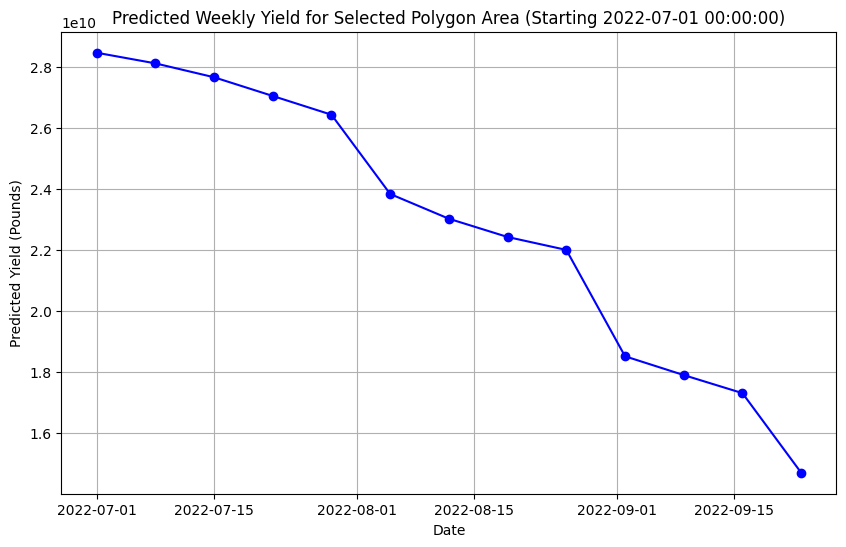

In [24]:
# Plot the predicted yields as a trend line
plt.figure(figsize=(10, 6))
plt.plot(dates, predicted_yields, marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Predicted Yield (Pounds)')
plt.title(f'Predicted Weekly Yield for Selected Polygon Area (Starting {start_date})')
plt.grid(True)
plt.show()

### Model Evaluation (Basic Evaluation Metrics)

In [25]:
# Function to evaluate the model on the test set
def evaluate_model(model, test_loader, mean, std, target_shape, device):
    model.eval()
    all_true = []
    all_pred = []
    
    with torch.no_grad():
        for inputs, labels, time_features in test_loader:
            if device != "cpu":
                inputs, labels, time_features = inputs.to(device), labels.to(device), time_features.to(device)
            
            outputs = model(inputs, time_features)
            labels = labels.unsqueeze(1).unsqueeze(2).expand(-1, target_shape[0], target_shape[1])
            
            all_true.append(labels.cpu().numpy())
            all_pred.append(outputs.cpu().numpy())
    
    all_true = np.concatenate(all_true).flatten()
    all_pred = np.concatenate(all_pred).flatten()
    
    mse = mean_squared_error(all_true, all_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_true, all_pred)
    r2 = r2_score(all_true, all_pred)
    
    return mse, rmse, mae, r2

# Evaluate the model on the test set
mse, rmse, mae, r2 = evaluate_model(model, test_loader, mean, std, target_shape, device)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 0.03171147406101227
Root Mean Squared Error (RMSE): 0.17807716131210327
Mean Absolute Error (MAE): 0.12822388112545013
R-squared (R²): 0.5511514042334249


### Model Evaluation (Cross Validation)

In [28]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []

def train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs, device):
    best_loss = float('inf')
    patience = 3
    trigger_times = 0
    
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for inputs, labels, time_features in tqdm(train_loader):
            inputs, labels, time_features = inputs.to(device), labels.to(device), time_features.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, time_features)
            labels = labels.unsqueeze(1).unsqueeze(2).expand(-1, target_shape[0], target_shape[1])
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        scheduler.step()
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

        # Early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping!")
                break

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels, time_features in val_loader:
            inputs, labels, time_features = inputs.to(device), labels.to(device), time_features.to(device)
            outputs = model(inputs, time_features)
            labels = labels.unsqueeze(1).unsqueeze(2).expand(-1, target_shape[0], target_shape[1])
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    print(f'Validation Loss: {val_loss}')
    return val_loss

for fold, (train_index, val_index) in enumerate(tscv.split(yield_data_weekly)):
    print(f"Fold {fold + 1}")

    train_dates = yield_data_weekly.index[train_index].intersection(evi_data_dict.keys())
    val_dates = yield_data_weekly.index[val_index].intersection(evi_data_dict.keys())

    train_index = yield_data_weekly.index.get_indexer(train_dates)
    val_index = yield_data_weekly.index.get_indexer(val_dates)

    evi_train = np.array([evi_data_dict[date] for date in train_dates])
    evi_val = np.array([evi_data_dict[date] for date in val_dates])
    time_features_train = yield_data_weekly.loc[train_dates][['month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'Volume (Pounds)', 'Cumulative Volumne (Pounds)']].values
    time_features_val = yield_data_weekly.loc[val_dates][['month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'Volume (Pounds)', 'Cumulative Volumne (Pounds)']].values
    labels_train = yield_data_weekly.loc[train_dates]['Volume (Pounds)'].values
    labels_val = yield_data_weekly.loc[val_dates]['Volume (Pounds)'].values

    evi_train = torch.tensor(evi_train, dtype=torch.float32).unsqueeze(1).unsqueeze(2).to(device)
    evi_val = torch.tensor(evi_val, dtype=torch.float32).unsqueeze(1).unsqueeze(2).to(device)
    time_features_train = torch.tensor(time_features_train, dtype=torch.float32).to(device)
    time_features_val = torch.tensor(time_features_val, dtype=torch.float32).to(device)
    labels_train = torch.tensor(labels_train, dtype=torch.float32).to(device)
    labels_val = torch.tensor(labels_val, dtype=torch.float32).to(device)

    train_loader = DataLoader(list(zip(evi_train, labels_train, time_features_train)), batch_size=2, shuffle=True)
    val_loader = DataLoader(list(zip(evi_val, labels_val, time_features_val)), batch_size=2, shuffle=False)

    model = HybridModel(CNNFeatureExtractor())
    model.apply(weights_init)
    model.to(device)
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.MSELoss()

    val_loss = train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs, device)
    
    model.eval()
    with torch.no_grad():
        outputs_val = model(evi_val, time_features_val)

    outputs_val_flat = outputs_val.cpu().numpy().flatten()
    labels_val_expanded = labels_val.unsqueeze(1).unsqueeze(2).expand(-1, target_shape[0], target_shape[1])
    labels_val_flat = labels_val_expanded.cpu().numpy().flatten()

    mse = mean_squared_error(labels_val_flat, outputs_val_flat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels_val_flat, outputs_val_flat)
    r2 = r2_score(labels_val_flat, outputs_val_flat)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average R-squared: {np.mean(r2_scores)}")

Fold 1


100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


Epoch 1, Loss: 0.19820818677544594


100%|██████████| 2/2 [00:00<00:00, 16.11it/s]


Epoch 2, Loss: 0.18792405724525452


100%|██████████| 2/2 [00:00<00:00, 16.77it/s]


Epoch 3, Loss: 0.15065795928239822


100%|██████████| 2/2 [00:00<00:00, 16.08it/s]


Epoch 4, Loss: 0.15908317267894745


100%|██████████| 2/2 [00:00<00:00, 15.72it/s]


Epoch 5, Loss: 0.16458916664123535


100%|██████████| 2/2 [00:00<00:00, 16.21it/s]


Epoch 6, Loss: 0.15739919617772102
Early stopping!
Validation Loss: 0.18647333979606628
Fold 2


100%|██████████| 3/3 [00:00<00:00, 12.34it/s]


Epoch 1, Loss: 0.32276228070259094


100%|██████████| 3/3 [00:00<00:00, 16.65it/s]


Epoch 2, Loss: 0.2035804440577825


100%|██████████| 3/3 [00:00<00:00, 16.75it/s]


Epoch 3, Loss: 0.17816766103108725


100%|██████████| 3/3 [00:00<00:00, 16.68it/s]


Epoch 4, Loss: 0.1523307959238688


100%|██████████| 3/3 [00:00<00:00, 16.72it/s]


Epoch 5, Loss: 0.1341608315706253


100%|██████████| 3/3 [00:00<00:00, 16.21it/s]


Epoch 6, Loss: 0.12525399525960287


100%|██████████| 3/3 [00:00<00:00, 16.60it/s]


Epoch 7, Loss: 0.11722503105799358


100%|██████████| 3/3 [00:00<00:00, 16.66it/s]


Epoch 8, Loss: 0.14279610415299734


100%|██████████| 3/3 [00:00<00:00, 16.58it/s]


Epoch 9, Loss: 0.11032003909349442


100%|██████████| 3/3 [00:00<00:00, 16.69it/s]


Epoch 10, Loss: 0.13092027232050896


100%|██████████| 3/3 [00:00<00:00, 16.74it/s]


Epoch 11, Loss: 0.100567360719045


100%|██████████| 3/3 [00:00<00:00, 16.72it/s]


Epoch 12, Loss: 0.10098385562499364


100%|██████████| 3/3 [00:00<00:00, 16.71it/s]


Epoch 13, Loss: 0.09416734551390012


100%|██████████| 3/3 [00:00<00:00, 15.80it/s]


Epoch 14, Loss: 0.10551578054825465


100%|██████████| 3/3 [00:00<00:00, 16.82it/s]


Epoch 15, Loss: 0.10235316057999928


100%|██████████| 3/3 [00:00<00:00, 16.68it/s]


Epoch 16, Loss: 0.1256045326590538
Early stopping!
Validation Loss: 0.09086662530899048
Fold 3


100%|██████████| 4/4 [00:00<00:00, 13.50it/s]


Epoch 1, Loss: 0.36572935059666634


100%|██████████| 4/4 [00:00<00:00, 16.63it/s]


Epoch 2, Loss: 0.21545109897851944


100%|██████████| 4/4 [00:00<00:00, 16.57it/s]


Epoch 3, Loss: 0.19158553704619408


100%|██████████| 4/4 [00:00<00:00, 16.49it/s]


Epoch 4, Loss: 0.15656202845275402


100%|██████████| 4/4 [00:00<00:00, 16.39it/s]


Epoch 5, Loss: 0.15146270208060741


100%|██████████| 4/4 [00:00<00:00, 16.60it/s]


Epoch 6, Loss: 0.11596086900681257


100%|██████████| 4/4 [00:00<00:00, 16.60it/s]


Epoch 7, Loss: 0.09979931078851223


100%|██████████| 4/4 [00:00<00:00, 16.55it/s]


Epoch 8, Loss: 0.10937555879354477


100%|██████████| 4/4 [00:00<00:00, 16.43it/s]


Epoch 9, Loss: 0.08644137438386679


100%|██████████| 4/4 [00:00<00:00, 16.52it/s]


Epoch 10, Loss: 0.08104754984378815


100%|██████████| 4/4 [00:00<00:00, 16.57it/s]


Epoch 11, Loss: 0.08240980003029108


100%|██████████| 4/4 [00:00<00:00, 16.62it/s]


Epoch 12, Loss: 0.08211528556421399


100%|██████████| 4/4 [00:00<00:00, 16.38it/s]


Epoch 13, Loss: 0.09086850751191378
Early stopping!
Validation Loss: 0.014455391094088554
Fold 4


100%|██████████| 5/5 [00:00<00:00, 11.97it/s]


Epoch 1, Loss: 0.2465425491333008


100%|██████████| 5/5 [00:00<00:00, 16.52it/s]


Epoch 2, Loss: 0.17091715335845947


100%|██████████| 5/5 [00:00<00:00, 16.26it/s]


Epoch 3, Loss: 0.14273011684417725


100%|██████████| 5/5 [00:00<00:00, 15.97it/s]


Epoch 4, Loss: 0.11378438472747802


100%|██████████| 5/5 [00:00<00:00, 16.11it/s]


Epoch 5, Loss: 0.10304250791668892


100%|██████████| 5/5 [00:00<00:00, 15.48it/s]


Epoch 6, Loss: 0.08888877779245377


100%|██████████| 5/5 [00:00<00:00, 16.37it/s]


Epoch 7, Loss: 0.08484105989336968


100%|██████████| 5/5 [00:00<00:00, 16.12it/s]


Epoch 8, Loss: 0.08871229588985444


100%|██████████| 5/5 [00:00<00:00, 15.86it/s]


Epoch 9, Loss: 0.07442525997757912


100%|██████████| 5/5 [00:00<00:00, 16.09it/s]


Epoch 10, Loss: 0.07057759463787079


100%|██████████| 5/5 [00:00<00:00, 16.08it/s]


Epoch 11, Loss: 0.07847579456865787


100%|██████████| 5/5 [00:00<00:00, 15.85it/s]


Epoch 12, Loss: 0.0757097590714693


100%|██████████| 5/5 [00:00<00:00, 15.55it/s]


Epoch 13, Loss: 0.07547184936702252
Early stopping!
Validation Loss: 0.340370237827301
Fold 5


100%|██████████| 6/6 [00:00<00:00, 13.71it/s]


Epoch 1, Loss: 0.27556608617305756


100%|██████████| 6/6 [00:00<00:00, 15.79it/s]


Epoch 2, Loss: 0.18404972180724144


100%|██████████| 6/6 [00:00<00:00, 15.88it/s]


Epoch 3, Loss: 0.1499897458901008


100%|██████████| 6/6 [00:00<00:00, 15.85it/s]


Epoch 4, Loss: 0.13552847194174925


100%|██████████| 6/6 [00:00<00:00, 16.45it/s]


Epoch 5, Loss: 0.1287969003121058


100%|██████████| 6/6 [00:00<00:00, 15.94it/s]


Epoch 6, Loss: 0.12043883341054122


100%|██████████| 6/6 [00:00<00:00, 15.67it/s]


Epoch 7, Loss: 0.1239405528952678


100%|██████████| 6/6 [00:00<00:00, 15.97it/s]


Epoch 8, Loss: 0.12532821049292883


100%|██████████| 6/6 [00:00<00:00, 16.27it/s]


Epoch 9, Loss: 0.11675217064718406


100%|██████████| 6/6 [00:00<00:00, 16.07it/s]


Epoch 10, Loss: 0.13632425044973692


100%|██████████| 6/6 [00:00<00:00, 16.34it/s]


Epoch 11, Loss: 0.10576897238691647


100%|██████████| 6/6 [00:00<00:00, 16.19it/s]


Epoch 12, Loss: 0.1350461554247886


100%|██████████| 6/6 [00:00<00:00, 15.91it/s]


Epoch 13, Loss: 0.11323839092316727


100%|██████████| 6/6 [00:00<00:00, 16.11it/s]

Epoch 14, Loss: 0.12273740116506815
Early stopping!
Validation Loss: 0.08159980177879333
Average MSE: 0.14275307953357697
Average RMSE: 0.34451329708099365
Average MAE: 0.3006556034088135
Average R-squared: -42.74429923856336
